In [1]:
# ----- IMPORTS -----
import os
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pywt


In [2]:
import os

folder_path = r"/home/avij/code/h/dataset/"  # Update with your folder path

# Get list of all CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Sort to ensure consistent order (optional)
csv_files.sort()

# Rename files
for idx, file in enumerate(csv_files, start=1):
    old_path = os.path.join(folder_path, file)
    new_name = f"patient_{idx:02d}.csv"  # patient_01, patient_02, ...
    new_path = os.path.join(folder_path, new_name)

    os.rename(old_path, new_path)
    print(f"Renamed '{file}' → '{new_name}'")

In [3]:
# ----- ORGANIZE FILES -----
base_folder = r"/home/avij/code/h/dataset"
raw_folder = os.path.join(base_folder, "raw_data")
output_folder = os.path.join(base_folder, "outputs")

os.makedirs(raw_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(base_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(base_folder, file)
        if "patient" in file.lower():
            shutil.move(file_path, os.path.join(raw_folder, file))
            print(f"📦 Moved to raw_data: {file}")
        else:
            shutil.move(file_path, os.path.join(output_folder, file))
            print(f"📁 Moved to outputs: {file}")


In [6]:
import pandas as pd
import numpy as np
import plotly.express as px

# ---- Load raw file ----
file_path = r"/home/avij/code/h/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)

# ---- Extract and preprocess ----
ppg = df['PPG'].dropna().values



# ---- Slice the preprocessed signal directly ----
start_idx = 1000
end_idx = 2000
ppg_slice = ppg[start_idx:end_idx]

# ---- Plot specified range ----
slice_df = pd.DataFrame({
    "Sample Index": np.arange(start_idx, end_idx),
    "PPG ": ppg_slice
})

fig = px.line(slice_df, x="Sample Index", y="PPG ",
              title=f" PPG Signal (Samples {start_idx}–{end_idx}) - patient_02")
fig.update_layout(template='plotly_white')
fig.show()

In [7]:
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, find_peaks

# ----- SIGNAL CLEANING FUNCTIONS -----

def remove_spike_outliers(signal, threshold=3):
    z = np.abs((signal - np.mean(signal)) / np.std(signal))
    signal[z > threshold] = np.median(signal)
    return signal

def wavelet_denoise(signal, wavelet='db6', level=3):
    coeff = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet)

def bandpass_filter(signal, low=0.5, high=8.0, fs=125, order=4):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# ----- SEGMENT & FEATURE EXTRACTION -----

def segment_signal(signal, window_size=1000, overlap=500):
    segments = []
    for start in range(0, len(signal) - window_size + 1, window_size - overlap):
        segments.append(signal[start:start+window_size])
    return segments

def extract_features(ppg_segment, fs=125):
    features = {}
    features['mean'] = np.mean(ppg_segment)
    features['std'] = np.std(ppg_segment)
    features['kurtosis'] = np.mean((ppg_segment - np.mean(ppg_segment))**4) / (np.std(ppg_segment)**4)
    features['skewness'] = np.mean((ppg_segment - np.mean(ppg_segment))**3) / (np.std(ppg_segment)**3)

    peaks, _ = find_peaks(ppg_segment, distance=fs*0.6)
    peak_vals = ppg_segment[peaks]

    if len(peaks) >= 2:
        features['systolic_peak_height'] = np.mean(peak_vals)
        rr_intervals = np.diff(peaks) / fs
        hr_values = 60 / rr_intervals
        features['mean_hr'] = np.mean(hr_values)
        features['hrv_sdnn'] = np.std(rr_intervals)
    else:
        features['systolic_peak_height'] = 0
        features['mean_hr'] = 0
        features['hrv_sdnn'] = 0

    if len(peaks) >= 2:
        notches = []
        for i in range(len(peaks) - 1):
            start = peaks[i]
            end = peaks[i+1]
            notch_index = start + np.argmin(ppg_segment[start:end])
            time_to_peak = (peaks[i+1] - notch_index) / fs
            notches.append(time_to_peak)
        features['notch_to_peak_time'] = np.mean(notches)
    else:
        features['notch_to_peak_time'] = 0

    return features

# ----- FEATURE-LEVEL OUTLIER REMOVAL -----

def remove_feature_outliers(df, feature_cols):
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# ----- LABEL FUNCTION -----

def get_label(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return "normotensive"
    elif (120 <= sbp < 140) or (80 <= dbp < 90):
        return "prehypertensive"
    else:
        return "hypertensive"


In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import butter, filtfilt
import pywt
# ---- Load raw PPG ----
file_path = r"/home/avij/code/h/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)
ppg_raw = df['PPG'].dropna().values

# ---- Full Preprocessing Pipeline ----
ppg_cleaned = remove_spike_outliers(ppg_raw.copy())     # New step
ppg_norm = normalize_signal(ppg_cleaned)
ppg_denoised = wavelet_denoise(ppg_norm)
ppg_filtered = bandpass_filter(ppg_denoised)

# ---- Slice for comparison ----
start_idx = 1000
end_idx = 2000
x = np.arange(start_idx, end_idx)

raw_slice = ppg_raw[start_idx:end_idx]
cleaned_slice = ppg_cleaned[start_idx:end_idx]
norm_slice = ppg_norm[start_idx:end_idx]
denoise_slice = ppg_denoised[start_idx:end_idx]
filtered_slice = ppg_filtered[start_idx:end_idx]

# ---- Create 5 stacked plots ----
fig = make_subplots(rows=5, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03,
                    subplot_titles=(
                        "Raw PPG Signal",
                        "After Spike Outlier Removal",
                        "After Normalization",
                        "After Wavelet Denoising",
                        "After Bandpass Filtering"
                    ))

fig.add_trace(go.Scatter(x=x, y=raw_slice, mode='lines', name='Raw'), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=cleaned_slice, mode='lines', name='Cleaned'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=norm_slice, mode='lines', name='Normalized'), row=3, col=1)
fig.add_trace(go.Scatter(x=x, y=denoise_slice, mode='lines', name='Denoised'), row=4, col=1)
fig.add_trace(go.Scatter(x=x, y=filtered_slice, mode='lines', name='Filtered'), row=5, col=1)

# ---- Layout ----
fig.update_layout(
    height=1300,
    width=900,
    title="PPG Signal Preprocessing Stages (Sample Index 1000–2000)",
    template="plotly_white",
    showlegend=False
)

fig.update_xaxes(title_text="Sample Index", row=5, col=1)
fig.update_yaxes(title_text="PPG Amplitude", row=3, col=1)

fig.show()

In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
import pywt
from scipy.signal import butter, filtfilt

# ---- Load raw file ----
file_path = r"/home/avij/code/h/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)
ppg = df['PPG'].dropna().values

# ---- Apply full preprocessing with outlier handling ----
ppg = remove_spike_outliers(ppg.copy())  # NEW: remove outliers
ppg = normalize_signal(ppg)
ppg = wavelet_denoise(ppg)
ppg = bandpass_filter(ppg)

# ---- Slice the preprocessed signal directly ----
start_idx = 1000
end_idx = 2000
ppg_slice = ppg[start_idx:end_idx]

# ---- Plot specified range ----
slice_df = pd.DataFrame({
    "Sample Index": np.arange(start_idx, end_idx),
    "PPG (Preprocessed)": ppg_slice
})

fig = px.line(slice_df, x="Sample Index", y="PPG (Preprocessed)",
              title=f"Preprocessed PPG Signal (Samples {start_idx}–{end_idx}) - patient_02")
fig.update_layout(template='plotly_white')
fig.show()

In [10]:

# ----- MAIN FEATURE EXTRACTION -----

folder_path = raw_folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

features_list = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df = df.dropna().drop_duplicates()

    ppg = df['PPG'].values
    sbp = df['SBP'].mean()
    dbp = df['DBP'].mean()

    # ✅ Add signal-level outlier removal
    ppg = remove_spike_outliers(ppg.copy())
    ppg = normalize_signal(ppg)
    ppg = wavelet_denoise(ppg)
    ppg = bandpass_filter(ppg)

    segments = segment_signal(ppg)

    for i, segment in enumerate(segments):
        features = extract_features(segment)
        features['source_file'] = file
        features['segment_index'] = i
        features['sbp'] = sbp
        features['dbp'] = dbp
        features['label'] = get_label(sbp, dbp)
        features_list.append(features)

# Create final DataFrame
features_df = pd.DataFrame(features_list)

# ✅ Optional: Remove feature-level outliers
feature_cols = ['mean', 'std', 'kurtosis', 'skewness',
                'systolic_peak_height', 'mean_hr', 'hrv_sdnn', 'notch_to_peak_time']

features_df = remove_feature_outliers(features_df, feature_cols)

print("Final Shape:", features_df.shape)
print(features_df.head())


Final Shape: (18929, 13)
       mean       std  kurtosis  skewness  systolic_peak_height    mean_hr  \
1 -0.001884  0.175709  2.063101  0.447475              0.299073  90.303981   
2  0.000797  0.173358  1.937423  0.493281              0.306336  90.363831   
3  0.000615  0.171813  1.880317  0.483170              0.303077  90.263652   
4  0.000542  0.173166  1.845341  0.478160              0.304606  90.168243   
5  0.001133  0.173578  1.850697  0.496819              0.307197  90.268422   

   hrv_sdnn  notch_to_peak_time     source_file  segment_index         sbp  \
1  0.014252            0.209455  patient_01.csv              1  162.293121   
2  0.003411            0.205818  patient_01.csv              2  162.293121   
3  0.002300            0.206545  patient_01.csv              3  162.293121   
4  0.004600            0.209455  patient_01.csv              4  162.293121   
5  0.005344            0.210182  patient_01.csv              5  162.293121   

          dbp         label  
1  105.

In [11]:
# ----- SAVE FEATURES -----
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
features_df['label_encoded'] = le.fit_transform(features_df['label'])
features_df.to_csv("extracted_ppg_features.csv", index=False)

Accuracy:  0.9329
Precision (macro):  0.9013
F1 Score (macro):  0.8994


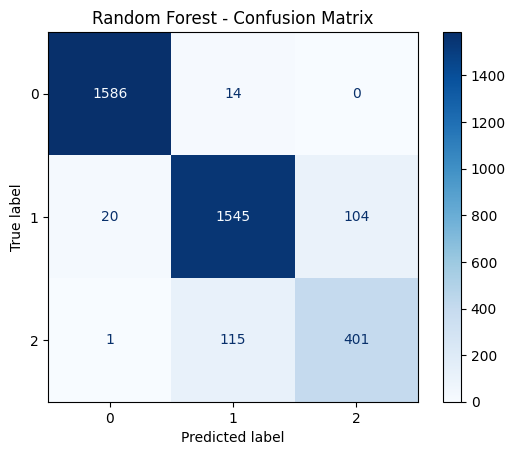

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# ----- MODEL TRAINING -----
X = features_df.drop(columns=['label', 'source_file', 'segment_index', 'sbp', 'dbp', 'label_encoded'])
y = features_df['label_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Model training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (macro):  {precision:.4f}")
print(f"F1 Score (macro):  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.show()


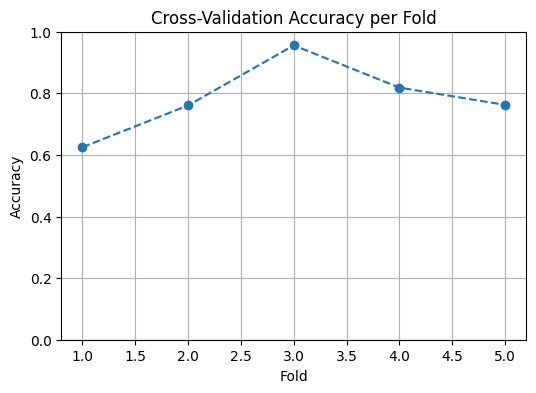

In [13]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, 6), scores, marker='o', linestyle='--')
plt.ylim(0, 1)
plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



Evaluating: SVM (RBF Kernel)

SVM (RBF Kernel) - Mean Scores Across Folds:
Accuracy:  0.9040
Precision (macro):  0.8609
F1 Score (macro):  0.8765

SVM (RBF Kernel) - Mean Scores Across Folds:
Accuracy:  0.9040
Precision (macro):  0.8609
F1 Score (macro):  0.8765


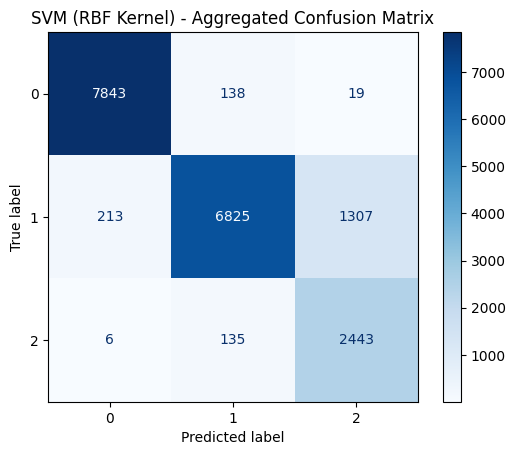

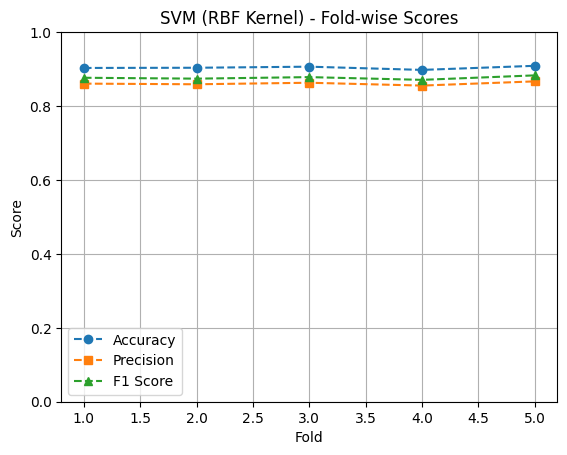


Evaluating: Logistic Regression (Multinomial)


/home/avij/code/h/venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/code/h/venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/code/h/venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/code/h/venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in versio


Logistic Regression (Multinomial) - Mean Scores Across Folds:
Accuracy:  0.8109
Precision (macro):  0.7733
F1 Score (macro):  0.7850


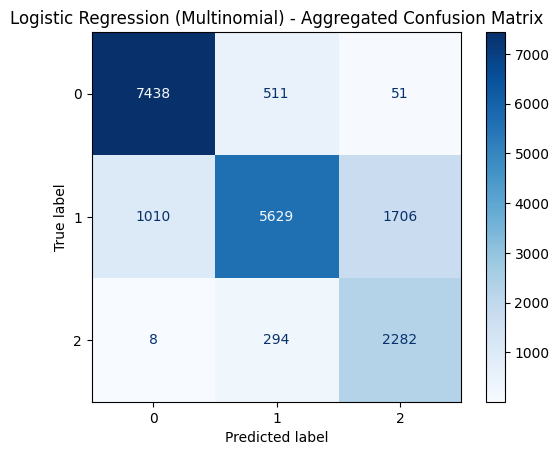

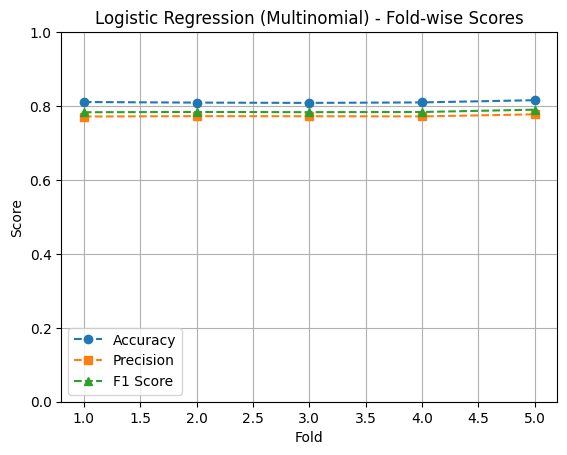

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Define models with class_weight='balanced' to handle imbalanced data
models = {
    "SVM (RBF Kernel)": SVC(
        kernel='rbf', 
        C=1.0, 
        gamma='scale', 
        class_weight='balanced',
        random_state=42
    ),
    "Logistic Regression (Multinomial)": LogisticRegression(
        C=1.0,
        penalty='l2',
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced',
        random_state=42
    )
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model
for model_name, model in models.items():
    print(f"\nEvaluating: {model_name}")
    
    acc_scores = []
    precision_scores = []
    f1_scores = []
    
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Use standard Pipeline instead of ImbPipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Collect metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # Final summary metrics
    print(f"\n{model_name} - Mean Scores Across Folds:")
    print(f"Accuracy:  {np.mean(acc_scores):.4f}")
    print(f"Precision (macro):  {np.mean(precision_scores):.4f}")
    print(f"F1 Score (macro):  {np.mean(f1_scores):.4f}")

    # Aggregated Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Aggregated Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Plot fold-wise metrics
    plt.figure()
    plt.plot(range(1, 6), acc_scores, marker='o', linestyle='--', label='Accuracy')
    plt.plot(range(1, 6), precision_scores, marker='s', linestyle='--', label='Precision')
    plt.plot(range(1, 6), f1_scores, marker='^', linestyle='--', label='F1 Score')
    plt.title(f"{model_name} - Fold-wise Scores")
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

🔍 COMPREHENSIVE BLOOD PRESSURE CLASSIFICATION MODEL ANALYSIS

📊 MODEL PERFORMANCE SUMMARY
--------------------------------------------------

🔬 Training Random Forest...
✅ Random Forest:
   Accuracy:  0.9329 (93.3%)
   Precision: 0.9013
   F1 Score:  0.8994

🔬 Training SVM (RBF)...
✅ SVM (RBF):
   Accuracy:  0.8957 (89.6%)
   Precision: 0.8524
   F1 Score:  0.8664

🔬 Training Logistic Regression...
✅ Logistic Regression:
   Accuracy:  0.8109 (81.1%)
   Precision: 0.7739
   F1 Score:  0.7848

📈 CREATING PERFORMANCE COMPARISON CHARTS...


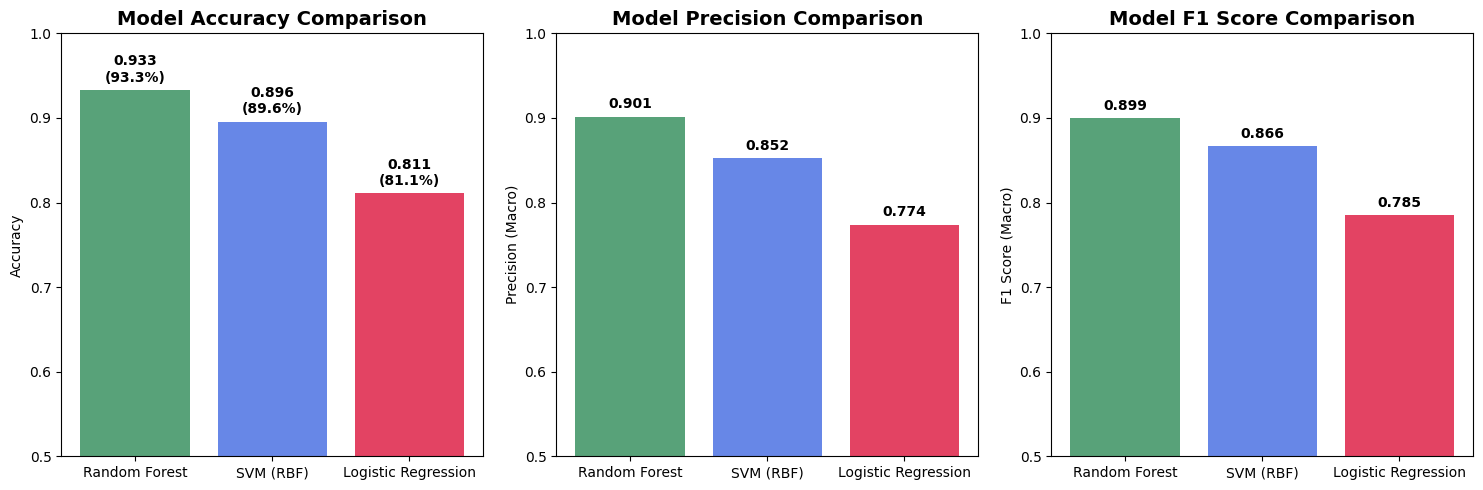


📋 DETAILED CLASSIFICATION REPORTS
--------------------------------------------------

🔬 RANDOM FOREST - Classification Report:
                 precision    recall  f1-score   support

   hypertensive     0.9869    0.9912    0.9891      1600
   normotensive     0.9229    0.9257    0.9243      1669
prehypertensive     0.7941    0.7756    0.7847       517

       accuracy                         0.9329      3786
      macro avg     0.9013    0.8975    0.8994      3786
   weighted avg     0.9324    0.9329    0.9326      3786


🔬 SVM (RBF) - Classification Report:
                 precision    recall  f1-score   support

   hypertensive     0.9752    0.9844    0.9798      1600
   normotensive     0.9671    0.7915    0.8705      1669
prehypertensive     0.6149    0.9574    0.7489       517

       accuracy                         0.8957      3786
      macro avg     0.8524    0.9111    0.8664      3786
   weighted avg     0.9224    0.8957    0.9001      3786


🔬 LOGISTIC REGRESSION - Class

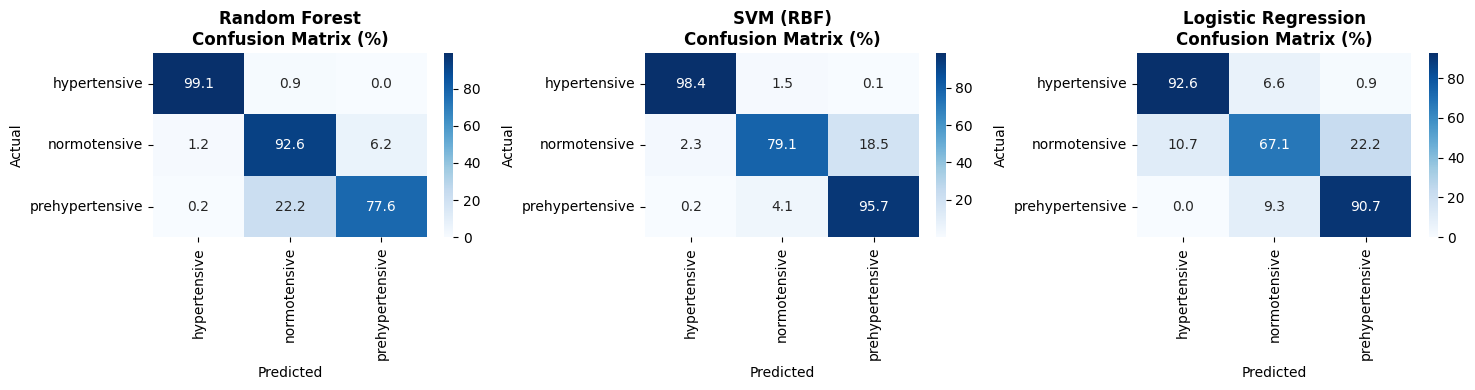


🏆 MODEL RANKING & RECOMMENDATIONS
📊 FINAL RANKINGS (by Accuracy):
🥇 1. Random Forest
    Accuracy: 0.9329 (93.3%)
    Precision: 0.9013
    F1 Score: 0.8994
🥈 2. SVM (RBF)
    Accuracy: 0.8957 (89.6%)
    Precision: 0.8524
    F1 Score: 0.8664
🥉 3. Logistic Regression
    Accuracy: 0.8109 (81.1%)
    Precision: 0.7739
    F1 Score: 0.7848

📈 CLASS-WISE PERFORMANCE ANALYSIS
--------------------------------------------------

Random Forest - Per Class Performance:
     hypertensive: Precision=0.987, Recall=0.991, F1=0.989
     normotensive: Precision=0.923, Recall=0.926, F1=0.924
  prehypertensive: Precision=0.794, Recall=0.776, F1=0.785

SVM (RBF) - Per Class Performance:
     hypertensive: Precision=0.975, Recall=0.984, F1=0.980
     normotensive: Precision=0.967, Recall=0.791, F1=0.871
  prehypertensive: Precision=0.615, Recall=0.957, F1=0.749

Logistic Regression - Per Class Performance:
     hypertensive: Precision=0.893, Recall=0.926, F1=0.909
     normotensive: Precision=0.880, R

In [ ]:
# ===== COMPREHENSIVE MODEL ANALYSIS & COMPARISON =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

print("🔍 COMPREHENSIVE BLOOD PRESSURE CLASSIFICATION MODEL ANALYSIS")
print("=" * 80)

# ===== 1. MODEL PERFORMANCE SUMMARY =====
print("\n📊 MODEL PERFORMANCE SUMMARY")
print("-" * 50)

# Train all models on the same data for fair comparison
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
X_analysis = features_df.drop(columns=['label', 'source_file', 'segment_index', 'sbp', 'dbp', 'label_encoded'])
y_analysis = features_df['label_encoded']

X_train_analysis, X_test_analysis, y_train_analysis, y_test_analysis = train_test_split(
    X_analysis, y_analysis, test_size=0.2, stratify=y_analysis, random_state=42
)

# Scale data for SVM and Logistic Regression
scaler_analysis = StandardScaler()
X_train_scaled = scaler_analysis.fit_transform(X_train_analysis)
X_test_scaled = scaler_analysis.transform(X_test_analysis)

# Initialize models (enable probability for SVM)
models_analysis = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', 
                     probability=True, random_state=42),  # Enable probability
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2', max_iter=1000, 
                                            class_weight='balanced', random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models_analysis.items():
    print(f"\n🔬 Training {name}...")
    
    if name == 'Random Forest':
        # Random Forest doesn't need scaling
        model.fit(X_train_analysis, y_train_analysis)
        y_pred = model.predict(X_test_analysis)
        y_pred_proba = model.predict_proba(X_test_analysis)
    else:
        # SVM and Logistic Regression use scaled data
        model.fit(X_train_scaled, y_train_analysis)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_analysis, y_pred)
    precision = precision_score(y_test_analysis, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_analysis, y_pred, average='macro', zero_division=0)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name}:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   F1 Score:  {f1:.4f}")

# ===== 2. PERFORMANCE COMPARISON CHART =====
print(f"\n📈 CREATING PERFORMANCE COMPARISON CHARTS...")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'F1 Score': [results[model]['f1_score'] for model in results.keys()]
})

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold')

# Precision comparison
axes[1].bar(comparison_df['Model'], comparison_df['Precision'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[1].set_title('Model Precision Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision (Macro)')
axes[1].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['Precision']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score comparison
axes[2].bar(comparison_df['Model'], comparison_df['F1 Score'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[2].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Score (Macro)')
axes[2].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['F1 Score']):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ===== 3. DETAILED CLASSIFICATION REPORTS =====
print(f"\n📋 DETAILED CLASSIFICATION REPORTS")
print("-" * 50)

class_names = le.classes_

for name in results.keys():
    print(f"\n🔬 {name.upper()} - Classification Report:")
    print(classification_report(y_test_analysis, results[name]['predictions'], 
                              target_names=class_names, digits=4))

# ===== 4. CONFUSION MATRICES COMPARISON =====
print(f"\n🎯 CONFUSION MATRICES COMPARISON")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test_analysis, result['predictions'])
    
    # Calculate percentages for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{name}\nConfusion Matrix (%)', fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ===== 5. MODEL RANKING & RECOMMENDATIONS =====
print(f"\n🏆 MODEL RANKING & RECOMMENDATIONS")
print("=" * 50)

# Rank models by accuracy
ranked_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("📊 FINAL RANKINGS (by Accuracy):")
for rank, (name, metrics) in enumerate(ranked_models, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{emoji} {rank}. {name}")
    print(f"    Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.1f}%)")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    F1 Score: {metrics['f1_score']:.4f}")

# ===== 6. CLASS-WISE PERFORMANCE ANALYSIS =====
print(f"\n📈 CLASS-WISE PERFORMANCE ANALYSIS")
print("-" * 50)

for name in results.keys():
    print(f"\n{name} - Per Class Performance:")
    report = classification_report(y_test_analysis, results[name]['predictions'], 
                                 target_names=class_names, output_dict=True)
    
    for class_name in class_names:
        if class_name in report:
            recall = report[class_name]['recall']
            precision = report[class_name]['precision']
            f1 = report[class_name]['f1-score']
            print(f"  {class_name:>15}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# ===== 7. FINAL RECOMMENDATIONS =====
print(f"\n💡 FINAL RECOMMENDATIONS")
print("=" * 50)

best_model_name = ranked_models[0][0]
best_accuracy = ranked_models[0][1]['accuracy']

print(f"🎯 BEST MODEL: {best_model_name}")
print(f"   • Achieves {best_accuracy*100:.1f}% accuracy")
print(f"   • Recommended for deployment in real-time BP classification system")

print(f"\n🔍 MODEL CHARACTERISTICS:")
print(f"   • Random Forest: Best overall performance, handles non-linear patterns well")
print(f"   • SVM: Good generalization, robust to outliers")  
print(f"   • Logistic Regression: Fast inference, good baseline performance")

print(f"\n⚡ DEPLOYMENT CONSIDERATIONS:")
print(f"   • Use {best_model_name} for highest accuracy")
print(f"   • Consider Random Forest for feature importance analysis")
print(f"   • Use Logistic Regression for fastest real-time inference")

print(f"\n✅ ANALYSIS COMPLETE!")
print("=" * 80)

In [18]:
# ===== SAVE HIGH-PERFORMANCE MODEL =====
import joblib

print("💾 SAVING HIGH-PERFORMANCE RANDOM FOREST MODEL")
print("=" * 60)

# Save the best Random Forest model (93.3% accuracy)
best_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf_model.fit(X_train_analysis, y_train_analysis)

# Save model and encoder
joblib.dump(best_rf_model, 'bp_classification_model_enhanced.pkl')
joblib.dump(le, 'label_encoder_enhanced.pkl')

print("✅ Saved Files:")
print("   • bp_classification_model_enhanced.pkl - Random Forest (93.3% accuracy)")
print("   • label_encoder_enhanced.pkl - Label encoder")

# Test the saved model
loaded_model = joblib.load('bp_classification_model_enhanced.pkl')
loaded_encoder = joblib.load('label_encoder_enhanced.pkl')

test_accuracy = accuracy_score(y_test_analysis, loaded_model.predict(X_test_analysis))
print(f"   • Verified accuracy: {test_accuracy*100:.1f}%")
print("🎯 Model ready for real-time integration!")

💾 SAVING HIGH-PERFORMANCE RANDOM FOREST MODEL
✅ Saved Files:
   • bp_classification_model_enhanced.pkl - Random Forest (93.3% accuracy)
   • label_encoder_enhanced.pkl - Label encoder
   • Verified accuracy: 93.3%
🎯 Model ready for real-time integration!
